In [1]:
# Required Libraries

#Base and Cleaning 
import json
import requests
import pandas as pd
import numpy as np
import emoji
import regex
import re
import string
from collections import Counter

#Visualizations
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt 
import pyLDAvis.gensim
import chart_studio
import chart_studio.plotly as py 
import chart_studio.tools as tls

#Natural Language Processing (NLP)
import spacy
import gensim
from spacy.tokenizer import Tokenizer
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS as SW
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from wordcloud import STOPWORDS
stopwords = set(STOPWORDS)
     

In [2]:
df = pd.read_csv("Trump.csv", encoding='utf-8')
df.head(15)

,id,link,content,date,retweets,favorites,mentions,hashtags,geo
0,1698308935,https://twitter.com/realDonaldTrump/status/169...,Be sure to tune in and watch Donald Trump on L...,2009-05-04 20:54:25,500,868,NaN,NaN,NaN
1,1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump will be appearing on The View tom...,2009-05-05 03:00:10,33,273,NaN,NaN,NaN
2,1737479987,https://twitter.com/realDonaldTrump/status/173...,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 15:38:08,12,18,NaN,NaN,NaN
3,1741160716,https://twitter.com/realDonaldTrump/status/174...,New Blog Post: Celebrity Apprentice Finale and...,2009-05-08 22:40:15,11,24,NaN,NaN,NaN
4,1773561338,https://twitter.com/realDonaldTrump/status/177...,"""My persona will never be that of a wallflower...",2009-05-12 16:07:28,1399,1965,NaN,NaN,NaN
5,1776419923,https://twitter.com/realDonaldTrump/status/177...,"Miss USA Tara Conner will not be fired - ""I've...",2009-05-12 21:21:55,27,26,NaN,NaN,NaN
6,1786560616,https://twitter.com/realDonaldTrump/status/178...,Listen to an interview with Donald Trump discu...,2009-05-13 19:38:28,14,16,NaN,NaN,NaN
7,1796477499,https://twitter.com/realDonaldTrump/status/179...,"""Strive for wholeness and keep your sense of w...",2009-05-14 18:30:40,18,25,NaN,NaN,NaN
8,1806258917,https://twitter.com/realDonaldTrump/status/180...,"Enter the ""Think Like A Champion"" signed book ...",2009-05-15 16:13:13,14,8,NaN,NaN,NaN
9,1820624395,https://twitter.com/realDonaldTrump/status/182...,"""When the achiever achieves, it's not a platea...",2009-05-17 00:22:45,20,48,NaN,NaN,NaN


In [3]:
df = df[['id','content']]
df

,id,content
0,1698308935,Be sure to tune in and watch Donald Trump on L...
1,1701461182,Donald Trump will be appearing on The View tom...
2,1737479987,Donald Trump reads Top Ten Financial Tips on L...
3,1741160716,New Blog Post: Celebrity Apprentice Finale and...
4,1773561338,"""My persona will never be that of a wallflower..."
...,...,...
41117,1218962544372670467,I have never seen the Republican Party as Stro...
41118,1219004689716412416,Now Mini Mike Bloomberg is critical of Jack Wi...
41119,1219053709428248576,I was thrilled to be back in the Great State o...
41120,1219066007731310593,"“In the House, the President got less due proc..."


In [4]:
df.rename(columns = {'content':'tweet'}, inplace = True)

In [5]:
df

,id,tweet
0,1698308935,Be sure to tune in and watch Donald Trump on L...
1,1701461182,Donald Trump will be appearing on The View tom...
2,1737479987,Donald Trump reads Top Ten Financial Tips on L...
3,1741160716,New Blog Post: Celebrity Apprentice Finale and...
4,1773561338,"""My persona will never be that of a wallflower..."
...,...,...
41117,1218962544372670467,I have never seen the Republican Party as Stro...
41118,1219004689716412416,Now Mini Mike Bloomberg is critical of Jack Wi...
41119,1219053709428248576,I was thrilled to be back in the Great State o...
41120,1219066007731310593,"“In the House, the President got less due proc..."


In [6]:
df["tweet"]=df["tweet"].values.astype(str)

In [7]:
def give_emoji_free_text(text):
    emoji_list = [c for c in text if c in emoji.EMOJI_DATA]
    clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    return clean_text

def url_free_text(text):
    text = re.sub(r'http\S+', '', text)
    return text

call_emoji_free = lambda x: give_emoji_free_text(x)

df['emoji_free_tweets'] = df['tweet'].apply(call_emoji_free)

df['url_free_tweets'] = df['emoji_free_tweets'].apply(url_free_text)
     

In [8]:
nlp = spacy.load('en_core_web_lg')

In [9]:
# Tokenizer
tokenizer = Tokenizer(nlp.vocab)

In [10]:

custom_stopwords = ['hi','\n','\n\n', '&', ' ', '.', '-', 'got', "it's", 'it’s', "i'm", 'i’m','im', 'want', 'like', '$', '@']

# Customize stop words by adding to the default list
STOP_WORDS = nlp.Defaults.stop_words.union(custom_stopwords)

# ALL_STOP_WORDS = spacy + gensim + wordcloud
ALL_STOP_WORDS = STOP_WORDS.union(SW).union(stopwords)


tokens = []

for doc in tokenizer.pipe(df['url_free_tweets'], batch_size=500):
    doc_tokens = []    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())   
    tokens.append(doc_tokens)

# Makes tokens column
df['tokens'] = tokens

In [11]:
df

,id,tweet,emoji_free_tweets,url_free_tweets,tokens
0,1698308935,Be sure to tune in and watch Donald Trump on L...,Be sure to tune in and watch Donald Trump on L...,Be sure to tune in and watch Donald Trump on L...,"[sure, tune, watch, donald, trump, late, night..."
1,1701461182,Donald Trump will be appearing on The View tom...,Donald Trump will be appearing on The View tom...,Donald Trump will be appearing on The View tom...,"[donald, trump, appearing, view, tomorrow, mor..."
2,1737479987,Donald Trump reads Top Ten Financial Tips on L...,Donald Trump reads Top Ten Financial Tips on L...,Donald Trump reads Top Ten Financial Tips on L...,"[donald, trump, reads, financial, tips, late, ..."
3,1741160716,New Blog Post: Celebrity Apprentice Finale and...,New Blog Post: Celebrity Apprentice Finale and...,New Blog Post: Celebrity Apprentice Finale and...,"[new, blog, post:, celebrity, apprentice, fina..."
4,1773561338,"""My persona will never be that of a wallflower...","""My persona will never be that of a wallflower...","""My persona will never be that of a wallflower...","[""my, persona, wallflower, i’d, build, walls, ..."
...,...,...,...,...,...
41117,1218962544372670467,I have never seen the Republican Party as Stro...,I have never seen the Republican Party as Stro...,I have never seen the Republican Party as Stro...,"[seen, republican, party, strong, unified, rig..."
41118,1219004689716412416,Now Mini Mike Bloomberg is critical of Jack Wi...,Now Mini Mike Bloomberg is critical of Jack Wi...,Now Mini Mike Bloomberg is critical of Jack Wi...,"[mini, mike, bloomberg, critical, jack, wilson..."
41119,1219053709428248576,I was thrilled to be back in the Great State o...,I was thrilled to be back in the Great State o...,I was thrilled to be back in the Great State o...,"[thrilled, great, state, texas, tonight,, peop..."
41120,1219066007731310593,"“In the House, the President got less due proc...","“In the House, the President got less due proc...","“In the House, the President got less due proc...","[“in, house,, president, process, 9-11, terror..."


In [12]:
df['tokens_back_to_text'] = [' '.join(map(str, l)) for l in df['tokens']]
def get_lemmas(text):
    '''Used to lemmatize the processed tweets'''
    lemmas = []
    
    doc = nlp(text)
    
    # Something goes here :P
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

df['lemmas'] = df['tokens_back_to_text'].apply(get_lemmas)
     

In [13]:
# Make lemmas a string again
df['lemmas_back_to_text'] = [' '.join(map(str, l)) for l in df['lemmas']]

# Tokenizer function
def tokenize(text):
    # Removing url's
    pattern = r"http\S+"
    
    tokens = re.sub(pattern, "", text) # https://www.youtube.com/watch?v=O2onA4r5UaY
    tokens = re.sub('[^a-zA-Z 0-9]', '', text)
    tokens = re.sub('[%s]' % re.escape(string.punctuation), '', text) # Remove punctuation
    tokens = re.sub('\w*\d\w*', '', text) # Remove words containing numbers
    tokens = re.sub('@*!*', '', text) # Remove @ ! $
    tokens = tokens.strip(',') # TESTING THIS LINE
    tokens = tokens.strip('?') # TESTING THIS LINE
    tokens = tokens.strip('!') # TESTING THIS LINE
    tokens = tokens.strip("'") # TESTING THIS LINE
    tokens = tokens.strip(".") # TESTING THIS LINE

    tokens = tokens.lower().split() # Make text lowercase and split it
    
    return tokens

# Apply tokenizer
df['lemma_tokens'] = df['lemmas_back_to_text'].apply(tokenize)
     

<>:12: DeprecationWarning: invalid escape sequence '\w'
<>:12: DeprecationWarning: invalid escape sequence '\w'
/tmp/ipykernel_47960/3831837225.py:12: DeprecationWarning: invalid escape sequence '\w'
  tokens = re.sub('\w*\d\w*', '', text) # Remove words containing numbers


In [14]:
df

,id,tweet,emoji_free_tweets,url_free_tweets,tokens,tokens_back_to_text,lemmas,lemmas_back_to_text,lemma_tokens
0,1698308935,Be sure to tune in and watch Donald Trump on L...,Be sure to tune in and watch Donald Trump on L...,Be sure to tune in and watch Donald Trump on L...,"[sure, tune, watch, donald, trump, late, night...",sure tune watch donald trump late night david ...,"[sure, tune, watch, donald, trump, late, night...",sure tune watch donald trump late night david ...,"[sure, tune, watch, donald, trump, late, night..."
1,1701461182,Donald Trump will be appearing on The View tom...,Donald Trump will be appearing on The View tom...,Donald Trump will be appearing on The View tom...,"[donald, trump, appearing, view, tomorrow, mor...",donald trump appearing view tomorrow morning d...,"[donald, trump, appear, view, tomorrow, mornin...",donald trump appear view tomorrow morning disc...,"[donald, trump, appear, view, tomorrow, mornin..."
2,1737479987,Donald Trump reads Top Ten Financial Tips on L...,Donald Trump reads Top Ten Financial Tips on L...,Donald Trump reads Top Ten Financial Tips on L...,"[donald, trump, reads, financial, tips, late, ...",donald trump reads financial tips late david l...,"[donald, trump, read, financial, tip, late, da...",donald trump read financial tip late david let...,"[donald, trump, read, financial, tip, late, da..."
3,1741160716,New Blog Post: Celebrity Apprentice Finale and...,New Blog Post: Celebrity Apprentice Finale and...,New Blog Post: Celebrity Apprentice Finale and...,"[new, blog, post:, celebrity, apprentice, fina...",new blog post: celebrity apprentice finale les...,"[new, blog, post, celebrity, apprentice, final...",new blog post celebrity apprentice finale less...,"[new, blog, post, celebrity, apprentice, final..."
4,1773561338,"""My persona will never be that of a wallflower...","""My persona will never be that of a wallflower...","""My persona will never be that of a wallflower...","[""my, persona, wallflower, i’d, build, walls, ...","""my persona wallflower i’d build walls cling t...","[persona, wallflower, build, wall, cle, --dona...",persona wallflower build wall cle --donald j. ...,"[persona, wallflower, build, wall, cle, --dona..."
...,...,...,...,...,...,...,...,...,...
41117,1218962544372670467,I have never seen the Republican Party as Stro...,I have never seen the Republican Party as Stro...,I have never seen the Republican Party as Stro...,"[seen, republican, party, strong, unified, rig...",seen republican party strong unified right now...,"[see, republican, party, strong, unify, right,...",see republican party strong unify right thank,"[see, republican, party, strong, unify, right,..."
41118,1219004689716412416,Now Mini Mike Bloomberg is critical of Jack Wi...,Now Mini Mike Bloomberg is critical of Jack Wi...,Now Mini Mike Bloomberg is critical of Jack Wi...,"[mini, mike, bloomberg, critical, jack, wilson...","mini mike bloomberg critical jack wilson, save...","[mini, mike, bloomberg, critical, jack, wilson...",mini mike bloomberg critical jack wilson save ...,"[mini, mike, bloomberg, critical, jack, wilson..."
41119,1219053709428248576,I was thrilled to be back in the Great State o...,I was thrilled to be back in the Great State o...,I was thrilled to be back in the Great State o...,"[thrilled, great, state, texas, tonight,, peop...","thrilled great state texas tonight, people kno...","[thrill, great, state, texas, tonight, people,...",thrill great state texas tonight people know t...,"[thrill, great, state, texas, tonight, people,..."
41120,1219066007731310593,"“In the House, the President got less due proc...","“In the House, the President got less due proc...","“In the House, the President got less due proc...","[“in, house,, president, process, 9-11, terror...","“in house, president process 9-11 terrorists g...","[house, president, process, 9, 11, terrorist, ...",house president process 9 11 terrorist get cor...,"[house, president, process, 9, 11, terrorist, ..."


## Topic Modeling

In [15]:
# Create a id2word dictionary
id2word = Dictionary(df['lemma_tokens'])
print(len(id2word))

37824


In [16]:
id2word

In [17]:
# Filtering Extremes
id2word.filter_extremes(no_below=2, no_above=.99)
print(len(id2word))

13730


In [18]:
# Creating a corpus object 
corpus = [id2word.doc2bow(d) for d in df['lemma_tokens']]

In [19]:
# Instantiating a Base LDA model 
base_model = LdaMulticore(corpus=corpus, num_topics=5, id2word=id2word, workers=12, passes=5)

In [20]:
# Filtering for words 
words = [re.findall(r'"([^"]*)"',t[1]) for t in base_model.print_topics()]

In [21]:
# Create Topics
topics = [' '.join(t[0:10]) for t in words]

In [22]:
# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
trump realdonaldtrump president good job time go donald obama year

------ Topic 1 ------
great trump people new today win thank news know bad

------ Topic 2 ------
great country people big border democrats president trump vote hillary

------ Topic 3 ------
realdonaldtrump thank trump great president need love trump2016 vote run

------ Topic 4 ------
great realdonaldtrump thank america good run trump interview president time



In [23]:
topics

['trump realdonaldtrump president good job time go donald obama year',
 'great trump people new today win thank news know bad',
 'great country people big border democrats president trump vote hillary',
 'realdonaldtrump thank trump great president need love trump2016 vote run',
 'great realdonaldtrump thank america good run trump interview president time']

In [24]:
t=[]
for i in topics:
    tmp = i.split()
    t.extend(tmp)

In [25]:
from wordcloud import WordCloud

In [26]:
wordcloud = WordCloud(background_color='lightyellow',width = 2000, height = 1000).generate(' '.join(t))

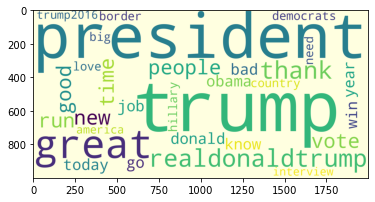

In [27]:
plt.imshow(wordcloud)

Thank you

In [28]:
# Compute Perplexity
# a measure of how good the model is. lower the better
base_perplexity = base_model.log_perplexity(corpus)
print('\nPerplexity: ', base_perplexity) 

# Compute Coherence Score
coherence_model = CoherenceModel(model=base_model, texts=df['lemma_tokens'], 
                                   dictionary=id2word, coherence='c_v')
coherence_lda_model_base = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence_lda_model_base)


Perplexity:  -7.910953933932184

Coherence Score:  0.30927438797517565


In [29]:
#Creating Topic Distance Visualization 
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(base_model, corpus, id2word)

/home/saanvi/.local/lib/python3.10/site-packages/pyLDAvis/_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.102038  0.039649       1        1  29.746198
3      0.090422 -0.017594       2        1  21.319838
0     -0.020534  0.045195       3        1  16.801185
4      0.075282  0.030942       4        1  16.164949
1     -0.043132 -0.098192       5        1  15.967829, topic_info=                 Term         Freq        Total Category  logprob  loglift
1961  realdonaldtrump  7360.000000  7360.000000  Default  30.0000  30.0000
105             thank  4591.000000  4591.000000  Default  29.0000  29.0000
73              great  6469.000000  6469.000000  Default  28.0000  28.0000
9               trump  4855.000000  4855.000000  Default  27.0000  27.0000
707           america  1800.000000  1800.000000  Default  26.0000  26.0000
...               ...          ...          ...      ...      ...      ...
450           country   219.024245  2105.673325   Topic5  -5.6491  -0.4286
1163            state   178.517247   892.453813   Topic5  -5.8536   0.2253
1247           medium   164.414439   662.352032   Topic5  -5.9359   0.4412
882       barackobama   163.350386   662.792131   Topic5  -5.9424   0.4340
323               job   168.003531  1657.711905   Topic5  -5.9143  -0.4546

[469 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
246        1  0.371812      $
246        2  0.048603      $
246        3  0.272176      $
246        4  0.233294      $
246        5  0.075334      $
...      ...       ...    ...
13414      4  0.080208  ایران
13710      3  0.947975     به
13712      3  0.954819     را
13715      3  0.884161      و
7612       5  0.867193      ★

[1345 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 5, 2])

In [ ]:
vectorizer = CountVectorizer()
data_vectorized = vectorizer.fit_transform(df['lemmas_back_to_text'])